# Stacking

The idea in this notebook is to implement stacking methods on the kickstarter data. Hopefully, to reach the ultimate score.

## Summary

<font color = grey>

- [With stolen models](#With-stolen-models)
 1. [Importing and preprocessing data](#Importing-and-preprocessing-data)
 2. [Training simple models withouth dimensionality reduction](#Training-simple-models-without-dimensionality-reduction)
    2.a. [Vanilla logistic regression](#Vanilla-logistic-regression)
    2.b. [Random forest](#Random-forest)
    2.c. [XGBoost](#XGBoost)
 3. [Stacking without dimensionality reduction](#Stacking-without-dimensionality-reduction)
    3.a. [Logistic regression](#Logistic-regression)
    3.b. [Neural network](#Neural-network)
    3.c. [Neural network : the return](#Neural-network-:-the-return)
    3.d. [Random forest top level](#Random-forest-top-level)
    3.e. [SVM](#SVM)
    3.f. [Majority vote](#Majority-vote)
- [With our own models](#With-our-own-models)
  1. [Stacking : logistic regression](#Stacking-:-logistic-regression)
  2. [Stacking : neural network](#Stacking-:-neural-network)
  3. [Stacking : majority vote](#Stacking-:-majority-vote)
  
- [Tests](#Tests)
- [Back to training a few stolen models on the datasets](#Back-to-training-a-few-stolen-models-on-the-datasets)
  1. [Datasets](#Datasets)
  2. [Training](#Training)

</font>

## With stolen models

First of all, we will design our functions with the help of the models stolen from the notebook found online. This will help us gain some time. In fact, the author already ran grid searches over her models (extremely expensive), so instead of starting over, we will just take the same models with the same parameters, without dimensionality reduction. After we built our proper functions, we will just have to start over with our one models that perform as accurately as possible on their own in order to get the best results with the full stack.

### Importing and preprocessing data 

In [1]:
# Importing the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
import itertools
import time
import xgboost as xgb
import glob
import pickle as pk
from keras.models import load_model
import os
from sklearn.metrics import precision_recall_fscore_support
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.utils import to_categorical
import numpy as np
from sklearn.linear_model import LogisticRegression as LR;

Using TensorFlow backend.
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [2]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('D:/Utilisateurs/Bastien/Documents/Cours/CentraleSupelec/Electifs/Machine Learning/Projet/kickstarter-analysis/data/Kickstarter*.csv')], ignore_index = True)

In [7]:
# Dropping columns that are mostly null
df.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=True)

# Dropping columns that aren't useful
df.drop(['converted_pledged_amount', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'fx_rate', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state_changed_at', 'urls', 'usd_type'], axis=1, inplace=True)

In [8]:
# Converting dates from unix to datetime
cols_to_convert = ['created_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c], origin='unix', unit='s')

In [9]:
# Count length of each blurb
df['blurb_length'] = df['blurb'].str.split().str.len()

# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

In [10]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)

# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

In [11]:
df.drop('disable_communication', axis=1, inplace=True)

In [12]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [13]:
# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

In [14]:
# Dropping location
df.drop('location', axis=1, inplace=True)

In [15]:
# Count length of each name
df['name_length'] = df['name'].str.split().str.len()
# Drop name variable
df.drop('name', axis=1, inplace=True)

In [16]:
df['usd_pledged'] = round(df['usd_pledged'],2)

In [17]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only

# Launch day of week
df['launch_day'] = df['launched_at'].dt.weekday_name

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.weekday_name

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [18]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour # Extracting hour from launched_at

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) # Calculates bins from launch_time

df.drop('launch_hour', axis=1, inplace=True)

In [19]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour # Extracting hour from deadline

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

In [20]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

In [21]:
# Replacing null values for blurb_length with 0
df.blurb_length.fillna(0, inplace=True)

In [22]:
# Dropping projects which are not successes or failures
df = df[df['state'].isin(['successful', 'failed'])]

In [23]:
# Checking for duplicates of individual projects, and sorting by id
duplicates = df[df.duplicated(subset='id')]
print(f"Of the {len(df)} projects in the dataset, there are {len(df[df.duplicated(subset='id')])} which are listed more than once.")
print(f"Of these, {len(df[df.duplicated()])} have every value in common between duplicates.")

Of the 192664 projects in the dataset, there are 23685 which are listed more than once.
Of these, 23674 have every value in common between duplicates.


In [24]:
# Dropping duplicates which have every value in common
df.drop_duplicates(inplace=True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
duplicated = df[df.duplicated(subset='id', keep=False)].sort_values(by='id')

In [26]:
df.drop_duplicates(subset='id', keep='first', inplace=True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
# Setting the id column as the index
df.set_index('id', inplace=True)
df.head()

,backers_count,category,country,created_at,deadline,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer
id,,,,,,,,,,,,,,,,,,,,,,,
287514992,21,music,US,2013-12-21 21:01:30,2014-02-08 22:37:26,False,2013-12-25 22:37:26,False,successful,802.00,26.0,rock,200.0,4,4,45,Wednesday,Saturday,December,February,10pm-12am,10pm-12am,38.19
385129759,97,art,US,2019-02-08 21:02:48,2019-03-05 16:00:11,False,2019-02-13 16:00:11,False,successful,2259.00,9.0,mixed media,400.0,5,5,20,Wednesday,Tuesday,February,March,4pm-6pm,4pm-6pm,23.29
681033598,88,photography,US,2016-10-23 17:06:24,2016-12-01 15:58:50,False,2016-11-01 14:58:50,True,successful,29638.00,25.0,photobooks,27224.0,9,9,30,Tuesday,Thursday,November,December,2pm-4pm,2pm-4pm,336.80
1031782682,193,fashion,IT,2018-10-24 08:32:00,2018-12-08 22:59:00,False,2018-10-27 23:56:22,False,successful,49075.15,13.0,footwear,45461.0,5,4,42,Saturday,Saturday,October,December,10pm-12am,10pm-12am,254.28
904085819,20,technology,US,2015-03-07 05:35:17,2015-04-08 16:36:57,False,2015-03-09 16:36:57,False,failed,549.00,22.0,software,1000.0,4,2,30,Monday,Wednesday,March,April,4pm-6pm,4pm-6pm,27.45


In [28]:
# Dropping columns and creating new dataframe
df_transformed = df.drop(['backers_count', 'created_at', 'deadline', 'is_starrable', 'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer'], axis=1)
df_transformed.head()

,category,country,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
id,,,,,,,,,,,,,,,
287514992,music,US,False,successful,26.0,200.0,4,4,45,Wednesday,Saturday,December,February,10pm-12am,10pm-12am
385129759,art,US,False,successful,9.0,400.0,5,5,20,Wednesday,Tuesday,February,March,4pm-6pm,4pm-6pm
681033598,photography,US,True,successful,25.0,27224.0,9,9,30,Tuesday,Thursday,November,December,2pm-4pm,2pm-4pm
1031782682,fashion,IT,False,successful,13.0,45461.0,5,4,42,Saturday,Saturday,October,December,10pm-12am,10pm-12am
904085819,technology,US,False,failed,22.0,1000.0,4,2,30,Monday,Wednesday,March,April,4pm-6pm,4pm-6pm


In [29]:
df_transformed['state'] = df_transformed['state'].replace({'failed': 0, 'successful': 1})

In [30]:
# Converting boolean features to string to include them in one-hot encoding
df_transformed['staff_pick'] = df_transformed['staff_pick'].astype(str)

In [73]:
# Creating dummy variables
df_transformed = pd.get_dummies(df_transformed)

Let us <font color = purple>**log-transform**</font> the data on the appropriate features. It allows better results.

In [74]:
# Assessing skewed distributions
cols_to_log = ['creation_to_launch_days', 'name_length', 'usd_goal']
# Replacing 0s with 0.01 and log-transforming
for col in cols_to_log:
    df_transformed[col] = df_transformed[col].astype('float64').replace(0.0, 0.01)
    df_transformed[col] = np.log(df_transformed[col])

In [75]:
X = df_transformed.drop('state', axis=1)
y = df_transformed.state

We finally save the datasets (both obvservations and labels in seperate datasets) in the right sub folder so as not to redo the whole data processing.

In [76]:
X.to_csv('datasets/observations.csv', header=X.columns )
y = y.values
y = pd.DataFrame(y)
y.to_csv('datasets/labels.csv')

Afterwards, we should separate the dataset in three similar subsets for further trainings, validation and tests. More specifically, one part will be used to train the level 0 models, the second part will be used to train the level 1 model and the last subset will be used to test the whole stack.

In [86]:
n_samples = X.values.shape[0]
n_subset = n_samples//3

X1 = X.iloc[:n_subset,:]
X2 = X.iloc[n_subset:2*n_subset,:]
X3 = X.iloc[2*n_subset:,:]

y1 = y.iloc[:n_subset,:]
y2 = y.iloc[n_subset:2*n_subset,:]
y3 = y.iloc[2*n_subset:,:];

In [87]:
X1.to_csv('datasets/observations1.csv', header=X1.columns )
X2.to_csv('datasets/observations2.csv', header=X2.columns )
X3.to_csv('datasets/observations3.csv', header=X3.columns )
y1.to_csv('datasets/labels1.csv')
y2.to_csv('datasets/labels2.csv')
y3.to_csv('datasets/labels3.csv')

### Training simple models without dimensionality reduction
Now, we should train each of the model specified in the model notebook, on each of the subsets. However, note that the data was <font color=purple>**log-transformed**</font> to accomplish better results.
#### Vanilla logistic regression

In [88]:
# Fitting logistic regression models with default parameters
logreg1 = LogisticRegression()
logreg1.fit(X1,y1)
logreg2 = LogisticRegression()
logreg2.fit(X2,y2)
logreg3 = LogisticRegression()
logreg3.fit(X3,y3)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Now, we should save the trained models in the proper sub folder.

In [7]:
import pickle as pk

In [90]:
logistic_list = [logreg1,logreg2,logreg3]

for i in range(3):
    with open('stacking_test/logreg'+str(i+1)+'.txt','wb') as fichier:
        pickler = pk.Pickler(fichier)
        pickler.dump(logistic_list[i])

#### Random forest

In [92]:
rf1 = RandomForestClassifier(max_depth=35, min_samples_split=0.001, n_estimators=400)
rf1.fit(X1, y1)
rf2 = RandomForestClassifier(max_depth=35, min_samples_split=0.001, n_estimators=400)
rf2.fit(X2, y2)
rf3 = RandomForestClassifier(max_depth=35, min_samples_split=0.001, n_estimators=400)
rf3.fit(X3, y3);

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.001,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
rf_list = [rf1,rf2,rf3]
for i in range(3):
    with open('stacking_test/random_forest_'+str(i+1)+'.txt','wb') as fichier:
        pickler = pk.Pickler(fichier)
        pickler.dump(rf_list[i])

#### XGBoost

In [94]:
xgb1 = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, min_child_weight=100, n_estimators=100, subsample=0.7)
xgb1.fit(X1, y1)
xgb2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, min_child_weight=100, n_estimators=100, subsample=0.7)
xgb2.fit(X2, y2)
xgb3 = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, min_child_weight=100, n_estimators=100, subsample=0.7)
xgb3.fit(X3, y3);

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=35,
              min_child_weight=100, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [96]:
xgb_list = [xgb1,xgb2,xgb3]
for i in range(3):
    with open('stacking_test/xgb_'+str(i+1)+'.txt','wb') as fichier:
        pickler = pk.Pickler(fichier)
        pickler.dump(xgb_list[i])

### Stacking without dimensionality reduction

In [2]:
def stacked_dataset(models, inputX, scaler = None, fit_scaler = False):
    """
    Input : list of learners, np.array, sklearn object, bool
    Output: np.array
    The function takes a list of pretrained models, the training observations and eventually a standard scaler to scale 
    the stacked data. The last boolean is an indicator to tell if the standard scaler ought to be trained or if it has already
    been. Then it returns the concatenated predictions
    of each and every model in a flattened array. The output will be the input of the level 1 model to train with
    trainStack
    """
    stackX = None
    for model in models:
        # make prediction
        yhat = model.predict(inputX)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    if len(models) > 1:
        stackX = stackX.reshape((stackX.shape[1], stackX.shape[2]))
        
#     print("Il y a {0} modèles, le format des observations est : {1} et celui des observations empilées est : {2}".format(len(models), inputX.shape, stackX.shape))
#     print("Les cinq premières lignes ressemblent à ceci : {}".format(stackX[:5,:]))

    if scaler is not None:
        if fit_scaler:
            stackX = scaler.fit_transform(stackX)
        else:
            stackX = scaler.transform(stackX)
    
#     print('Les résultats agglomérés des modèles ressemblent à ça : {}'.format(stackX[:5,:]))
    return stackX

In [38]:
def trainStack(first_models, final_model, X_train, y_train, is_MLP = False, epochs = 300, scaler = None, fit_scaler = False):
    """
    Input : list of learners, learner, np.array, np.array, bool, int, sklearn object, bool
    Output : learner
    The function takes the level 0 trained learners, the level 1 learner to train, the training observations, the 
    training labels, the boolean telling whether or not the top-level classifier is a Multi-Layer Perceptron and the integer
    corresponding to the number of training epochs if we have an MLP. The two last arguments are a respectively a 
    standard scaler in case we need to scale our data and a boolean telling whether or not it has to be trained.
    It returns the level 1 trained model.
    """
    X_stacked = stacked_dataset(first_models, X_train, scaler = scaler, fit_scaler = fit_scaler)
    
    if is_MLP:
        y_train_categ = to_categorical(y_train)
#         print("Les labels pour l'entrainement ont cette forme : {}".format(y_train_categ[:5]))
        final_model.fit(X_stacked, y_train_categ, epochs = epochs, verbose = 0)
    else:
        final_model.fit(X_stacked, y_train)
    
    return final_model

In [39]:
def predictStack(first_models, final_model, X_test, scaler = None):
    """
    Input : list of learners, learner, array-like, sklearn object
    Output : array-like
    The function takes the first-level trained models, the top-level trained model, the test set and eventually a scaler 
    that scales the X_test data with a pretrained scaler (trained on the training data) and returns 
    the predictions of the stack on the test set.
    """
    X_stacked = stacked_dataset(first_models, X_test, scaler = scaler)
        
    y_predicted = final_model.predict(X_stacked)
    return y_predicted

#### Logistic regression
We will use the logistic regression as the top-level trainer.

In [8]:
#Loading the pretrained models
logreg1, rf1, xgb1 = None, None, None

with open('stacking_test/logreg1.txt','rb') as fichier:
    pickler = pk.Unpickler(fichier)
    logreg1 = pickler.load()

with open('stacking_test/random_forest_1.txt','rb') as fichier:
    pickler = pk.Unpickler(fichier)
    rf1 = pickler.load()
    
with open('stacking_test/xgb_1.txt','rb') as fichier:
    pickler = pk.Unpickler(fichier)
    xgb1 = pickler.load()

In [56]:
# Loading the datasets. Since the models were trained on the first part of the dataset, we must choose different datasets this
# time, for instance the second subsets
X_train = pd.read_csv('datasets/observations2.csv')
y_train = pd.read_csv('datasets/labels2.csv')
X_train.drop('id',axis=1,inplace=True)
y_train.drop('Unnamed: 0',axis=1,inplace=True);

In [57]:
top_model1 = LogisticRegression();

In [58]:
stack1 = trainStack([logreg1, rf1, xgb1], top_model1, X_train, y_train)

Il y a 3 modèles, le format des observations est : (56326, 106) et celui des observations empilées est : (56326, 3)
Les cinq premières lignes ressemblent à ceci : [[0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]


D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now, it's time to import the test sets.

In [59]:
X_test = pd.read_csv('datasets/observations3.csv')
y_test = pd.read_csv('datasets/labels3.csv')
X_test.drop('id',axis=1,inplace=True)
y_test.drop('Unnamed: 0',axis=1,inplace=True);

In [60]:
y_predicted = predictStack([logreg1, rf1, xgb1], stack1, X_test)

Il y a 3 modèles, le format des observations est : (56327, 106) et celui des observations empilées est : (56327, 3)
Les cinq premières lignes ressemblent à ceci : [[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]


In [61]:
from sklearn.metrics import precision_recall_fscore_support

In [69]:
# Displaying the results
y_train_pred = predictStack([logreg1, rf1, xgb1], stack1, X_train)

stack1_test_precision, stack1_test_recall, stack1_test_f1score, stack1_test_support = precision_recall_fscore_support(y_test, y_predicted, average='weighted')
stack1_train_precision, stack1_train_recall, stack1_train_f1score, stack1_train_support = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
stack1_results = {'Precision':[stack1_test_precision, stack1_train_precision], 'Recall':[stack1_test_recall, stack1_train_recall], 'F1_score': [stack1_test_f1score, stack1_train_f1score]}
stack1_results = pd.DataFrame(stack1_results, index=['Test','Train'])
stack1_results

Il y a 3 modèles, le format des observations est : (56326, 106) et celui des observations empilées est : (56326, 3)
Les cinq premières lignes ressemblent à ceci : [[0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]


,Precision,Recall,F1_score
Test,0.747522,0.736698,0.731683
Train,0.746376,0.744221,0.738814


Let's save the first trained model.

In [46]:
with open('stacking_test/stack_logreg.txt','wb') as fichier:
    pickler = pk.Pickler(fichier)
    pickler.dump(stack1)

We should renew the experiment with models trained on different datasets.

#### Neural network
This time, we will use a neural network as a top-level learner. **Beware**, we will use <font color = purple>TensorFlow and Keras</font> to implemant our neural networks. Both packages **must** be used in a virutal environment with **Python 3.6**.

In [38]:
top_model2 = Sequential()
top_model2.add(Dense(25, input_dim=3, activation='relu'))
top_model2.add(Dense(2, activation='softmax'))
top_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy']);

In [39]:
stack2 = trainStack([logreg1, rf1, xgb1], top_model2, X_train, y_train, is_MLP = True)

Il y a 3 modèles, le format des observations est : (56326, 106) et celui des observations empilées est : (56326, 3)
Les cinq premières lignes ressemblent à ceci : [[0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]
Les labels pour l'entrainement ont cette forme : [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Instructions for updating:
Use tf.cast instead.


In [45]:
filename = 'stacking_test/stack_MLP1.h5'
stack2.save(filename)

In [40]:
y_predicted2 = predictStack([logreg1, rf1, xgb1], stack2, X_test)

Il y a 3 modèles, le format des observations est : (56327, 106) et celui des observations empilées est : (56327, 3)
Les cinq premières lignes ressemblent à ceci : [[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]


Les prédictions retournées par le réseau de neurone sont en fait des probabilités d'appartenance à une classe ou à une autre
Plutôt que de le réentrainer (c'est très long), nous remplaceront la ligne de deux valeurs par un zéro si la valeur de la première colonne est la plus grande, par un 1 si la valeur de la deuxièe colonne est la plus grande.

In [71]:
y_pred_flat2 = np.array(y_predicted2.shape[0]*[0])


for i in range(y_predicted2.shape[0]):
    if y_predicted2[i,0] < y_predicted2[i,1]:
        y_pred_flat2[i] = 1
        
y_train_pred2 = predictStack([logreg1, rf1, xgb1], stack2, X_train)
y_train_pred_flat2 = np.array(y_train_pred2.shape[0]*[0])

for i in range(y_train_pred2.shape[0]):
    if y_train_pred2[i,0] < y_train_pred2[i,1]:
        y_train_pred_flat2[i] = 1
        

Il y a 3 modèles, le format des observations est : (56326, 106) et celui des observations empilées est : (56326, 3)
Les cinq premières lignes ressemblent à ceci : [[0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]


In [72]:
# Displaying the results
stack2_test_precision, stack2_test_recall, stack2_test_f1score, stack2_test_support = precision_recall_fscore_support(y_test, y_pred_flat2, average='weighted')
stack2_train_precision, stack2_train_recall, stack2_train_f1score, stack2_train_support = precision_recall_fscore_support(y_train, y_train_pred_flat2, average='weighted')
stack2_results = {'Precision':[stack2_test_precision, stack2_train_precision], 'Recall':[stack2_test_recall, stack2_train_recall], 'F1_score': [stack2_test_f1score, stack2_train_f1score]}
stack2_results = pd.DataFrame(stack2_results, index=['Test','Train'])
stack2_results

,Precision,Recall,F1_score
Test,0.745820,0.740853,0.738060
Train,0.746055,0.746636,0.743767


The precision is worse than before but the F1-score rose from 0.731 to 0.738 which is not a considerable improvement. Fortunately, we cannot lay the blame on overfitting.

#### Neural network : the return
 This time, we'll try a different architecture. Maybe we don't need 25 neurons in the first layer. However, it is probably useless to add many more layers. However, we will try out a three-layer perceptron and see how it goes. We will try different loss functions as well. And finally, we will train our exemples on smaller datasets to compute adequate results in reasonable time.

First of all, since it proved useful to transform the results computed by the perceptron (probabilities instead of classes), we will build a function to do the same thing. We will need a function to display the final results as well.

In [38]:
def probabilitiesToClass(array):
    """
    Input: np.array of size (n,2)
    Output : np.array of size (n,)
    The function takes the array whose lines are the observations and column values correspond to the probability of belonging 
    to a given class. If the probability in a given column is superior to 0.5, then we will return the number of that class. 
    For instance : [0.33,0.66] for an observation will render [1] and [0.7,0.3] will render [0].
    """
    res = np.array(array.shape[0]*[0])
    for i in range(array.shape[0]):
        if array[i,1] > array[i,0]:
            res[i] = 1
    return res

In [44]:
def displayPerformances(y_test, y_test_pred, y_train, y_train_pred):
    """
    Input: np.array (n,1), np.array (n,1), np.array (N,1), np.array (N,1)
    Output : pd.DataFrame
    The function takes the labels from the training set, the predicted labels, and the same for the test set. It returns
    a DataFrame containing the values on each data set of the precision, the recall and the f1-score.
    """
    test_precision, test_recall, test_f1score, test_support = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    train_precision, train_recall, train_f1score, train_support = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
    results = {'Precision':[test_precision, train_precision], 'Recall':[test_recall, train_recall], 'F1_score': [test_f1score, train_f1score]}
    results = pd.DataFrame(results, index=['Test','Train'])
    
    return results

Now we can try out a new neural network.

In [78]:
top_model3 = Sequential()
top_model3.add(Dense(7, input_dim=3, activation='relu'))
top_model3.add(Dense(7, activation='relu'))
top_model3.add(Dense(2, activation='softmax'))
top_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy']);

In [80]:
# We train this perceptron on only 2000 samples
stack3 = trainStack([logreg1, rf1, xgb1], top_model3, X_train.iloc[:2000,:], y_train.iloc[:2000,:], is_MLP = True)

In [81]:
#Let's save the trained model
filename = 'stacking_test/stack_MLP2.h5'
stack3.save(filename)

In [82]:
y_test_pred3 = predictStack([logreg1, rf1, xgb1], stack3, X_test.iloc[:1000,:])
y_test_pred_flat3 = probabilitiesToClass(y_test_pred3)
y_train_pred3 = predictStack([logreg1, rf1, xgb1], stack3, X_train.iloc[:2000,:])
y_train_pred_flat3 = probabilitiesToClass(y_train_pred3)

In [83]:
res3 = displayPerformances(y_test.iloc[:1000,:], y_test_pred_flat3, y_train.iloc[:2000,:], y_train_pred_flat3)
res3

,Precision,Recall,F1_score
Test,0.737591,0.7340,0.728333
Train,0.760837,0.7645,0.758654


The stack overfitted this time. It does not make a huge difference, however, it is worse than previous computations. Let us try the same neural network as before but with the new loss function : <font color = purple>binary_crossentropy</font>

In [88]:
top_model4 = Sequential()
top_model4.add(Dense(25, input_dim=3, activation='relu'))
top_model4.add(Dense(2, activation='softmax'))
top_model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy']);

In [89]:
# We train this perceptron on only 2000 samples
stack4 = trainStack([logreg1, rf1, xgb1], top_model4, X_train.iloc[:4000,:], y_train.iloc[:4000,:], is_MLP = True)

In [90]:
#Let's save the trained model
filename = 'stacking_test/stack_MLP3.h5'
stack4.save(filename)

In [91]:
y_test_pred4 = predictStack([logreg1, rf1, xgb1], stack4, X_test.iloc[:2000,:])
y_test_pred_flat4 = probabilitiesToClass(y_test_pred4)
y_train_pred4 = predictStack([logreg1, rf1, xgb1], stack4, X_train.iloc[:4000,:])
y_train_pred_flat4 = probabilitiesToClass(y_train_pred4)

In [92]:
res4 = displayPerformances(y_test.iloc[:2000,:], y_test_pred_flat4, y_train.iloc[:4000,:], y_train_pred_flat4)
res4

,Precision,Recall,F1_score
Test,0.740403,0.73950,0.734094
Train,0.749134,0.75125,0.747795


This neural network is obviously better since it does not overfit and has better results on the test set. However, it is a bit less efficient than the one trained on the full training set. Unfortunately, no sign of a breakthrough yet.

#### Random forest top level
What if the top-level learner was a random forest ? This algorithm has proved indecently efficient in past classification exercises. It is high time we tried it.

In [148]:
top_model5 = RandomForestClassifier(max_depth=10, min_samples_split=0.001, n_estimators=100)

In [149]:
# We train this perceptron on only 2000 samples
stack5 = trainStack([logreg1, rf1, xgb1], top_model5, X_train.iloc[:10000,:], y_train.iloc[:10000,:])

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [150]:
#Let's save the trained model
filename = 'stacking_test/stack_random_forest.txt'
with open(filename, 'wb') as fichier:
    pickler = pk.Pickler(fichier)
    pickler.dump(stack5)

In [151]:
y_test_pred5 = predictStack([logreg1, rf1, xgb1], stack5, X_test.iloc[:3000,:])
y_train_pred5 = predictStack([logreg1, rf1, xgb1], stack5, X_train.iloc[:10000,:])

In [152]:
res5 = displayPerformances(y_test.iloc[:3000,:], y_test_pred5, y_train.iloc[:10000,:], y_train_pred5)
res5

,Precision,Recall,F1_score
Test,0.739789,0.731667,0.727293
Train,0.753775,0.755400,0.751616


Results are not better than with a neural network. We ought to try with a support vector machine now.

#### SVM

It is highly advised to scale the data before any SVM operation. Standard Sclaing it is !

In [9]:
X_train = pd.read_csv('datasets/observations2.csv')
y_train = pd.read_csv('datasets/labels2.csv')
X_train.drop('id',axis=1,inplace=True)
y_train.drop('Unnamed: 0',axis=1,inplace=True)

X_test = pd.read_csv('datasets/observations3.csv')
y_test = pd.read_csv('datasets/labels3.csv')
X_test.drop('id',axis=1,inplace=True)
y_test.drop('Unnamed: 0',axis=1,inplace=True)

# sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test);

# The lines above were an error. We scaled the former data instead of scaling the inputs of the level 1 model.

In [19]:
from sklearn import svm
top_model_svm = svm.SVC(kernel = 'linear')
sc = StandardScaler()

In [24]:
# We train this model on only 2000 samples
stack_svm = trainStack([logreg1, rf1, xgb1], top_model_svm, X_train.iloc[:2000,:], y_train.iloc[:2000,:], scaler = sc, fit_scaler = True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
y_test_pred_svm = predictStack([logreg1, rf1, xgb1], stack_svm, X_test.iloc[:1000,:], scaler = sc)
y_train_pred_svm = predictStack([logreg1, rf1, xgb1], stack_svm, X_train.iloc[:2000,:], scaler =sc)

In [26]:
#Let's save the trained model
filename = 'stacking_test/stack_svm_linear.txt'
with open(filename, 'wb') as fichier:
    pickler = pk.Pickler(fichier)
    pickler.dump(stack_svm)

In [29]:
res_svm = displayPerformances(y_test.iloc[:1000,:], y_test_pred_svm, y_train.iloc[:2000,:], y_train_pred_svm)
res_svm

,Precision,Recall,F1_score
Test,0.737323,0.7320,0.725185
Train,0.757957,0.7615,0.754580


Let's try with a different kernel because this time. The results are ok but maybe we can do better.

In [30]:
top_model_svm_rbf = svm.SVC(kernel = 'rbf', gamma = 0.5)
sc = StandardScaler()

In [32]:
# We train this model on only 2000 samples
stack_svm_rbf = trainStack([logreg1, rf1, xgb1], top_model_svm_rbf, X_train.iloc[:2000,:], y_train.iloc[:2000,:], scaler = sc, fit_scaler = True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
y_test_pred_svm_rbf = predictStack([logreg1, rf1, xgb1], stack_svm_rbf, X_test.iloc[:1000,:], scaler = sc)
y_train_pred_svm_rbf = predictStack([logreg1, rf1, xgb1], stack_svm_rbf, X_train.iloc[:2000,:], scaler = sc)

In [34]:
#Let's save the trained model
filename = 'stacking_test/stack_svm_rbf.txt'
with open(filename, 'wb') as fichier:
    pickler = pk.Pickler(fichier)
    pickler.dump(stack_svm_rbf)

In [35]:
res_svm_rbf = displayPerformances(y_test.iloc[:1000,:], y_test_pred_svm_rbf, y_train.iloc[:2000,:], y_train_pred_svm_rbf)
res_svm_rbf

,Precision,Recall,F1_score
Test,0.737591,0.7340,0.728333
Train,0.760837,0.7645,0.758654


This time, the results are a weeny bit better. Let's try with a different kernel.

In [36]:
top_model_svm_sigmoid = svm.SVC(kernel = 'sigmoid', coef0 = 1)
sc = StandardScaler()

In [38]:
# We train this model on only 2000 samples
stack_svm_sigmoid = trainStack([logreg1, rf1, xgb1], top_model_svm_sigmoid, X_train.iloc[:10000,:], y_train.iloc[:10000,:], scaler = sc, fit_scaler = True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
y_test_pred_svm_sigmoid = predictStack([logreg1, rf1, xgb1], stack_svm_sigmoid, X_test.iloc[:2000,:], scaler = sc)
y_train_pred_svm_sigmoid = predictStack([logreg1, rf1, xgb1], stack_svm_sigmoid, X_train.iloc[:10000,:], scaler = sc)

In [40]:
#Let's save the trained model
filename = 'stacking_test/stack_svm_sigmoid.txt'
with open(filename, 'wb') as fichier:
    pickler = pk.Pickler(fichier)
    pickler.dump(stack_svm_sigmoid)

In [41]:
res_svm_sigmoid = displayPerformances(y_test.iloc[:2000,:], y_test_pred_svm_sigmoid, y_train.iloc[:10000,:], y_train_pred_svm_sigmoid)
res_svm_sigmoid

,Precision,Recall,F1_score
Test,0.749945,0.7300,0.713253
Train,0.755968,0.7461,0.732821


Let's try with a different kernel because this time, the results are **worse**.

In [42]:
top_model_svm_poly = svm.SVC(kernel = 'poly', degree = 2, coef0 = 1)
sc = StandardScaler()

In [43]:
# We train this model on only 2000 samples
stack_svm_poly = trainStack([logreg1, rf1, xgb1], top_model_svm_poly, X_train.iloc[:10000,:], y_train.iloc[:10000,:], scaler = sc, fit_scaler = True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
y_test_pred_svm_poly = predictStack([logreg1, rf1, xgb1], stack_svm_poly, X_test.iloc[:2000,:], scaler = sc)
y_train_pred_svm_poly = predictStack([logreg1, rf1, xgb1], stack_svm_poly, X_train.iloc[:10000,:], scaler = sc)

In [45]:
#Let's save the trained model
filename = 'stacking_test/stack_svm_poly.txt'
with open(filename, 'wb') as fichier:
    pickler = pk.Pickler(fichier)
    pickler.dump(stack_svm_poly)

In [46]:
res_svm_poly = displayPerformances(y_test.iloc[:2000,:], y_test_pred_svm_poly, y_train.iloc[:10000,:], y_train_pred_svm_poly)
res_svm_poly

,Precision,Recall,F1_score
Test,0.742472,0.7425,0.738165
Train,0.752244,0.7542,0.751212


It is not too bad actually. However, we will see below that a majority vote is just a bit better.

#### Majority vote

We did still did not implemant a majority vote on the result given by our level 0 classifiers. Maybe it's time. However, one should keep in mind that ensemble learning and stacking may behave better with **a lot more level 0 classifiers** than currently. Indeed, to take a majority vote, it may seem better to have a lot of different outputs from level 0 learners. Anyway, we'll keep it short with our 3 classifiers.

In [57]:
def majorityVote(first_models, X_train):
    """
    Input : list of learners, np.array (N,d)
    Output : np.array (N,)
    The function takes the level 0 trained learners, and the training observations. It returns the array containing the majority
    vote coming from the level-0 classifiers.
    """
    
    X_stacked = stacked_dataset(first_models, X_train)
    res = np.array(X_stacked.shape[0]*[0])
    
    for i in range(X_stacked.shape[0]):
        line = X_stacked[i,:]
        if (line == 1).sum() > (line == 0).sum():
            res[i] = 1
    
    return res

In [168]:
y_train_pred6 = majorityVote([logreg1, rf1, xgb1], X_train)

[[0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]]


In [170]:
# The test dataframes are meaningless here but we keep them for they are mandatory arguments to the function
res6 = displayPerformances(y_test.iloc[:3000,:], y_test_pred5, y_train, y_train_pred6)
res6

,Precision,Recall,F1_score
Test,0.739789,0.731667,0.727293
Train,0.746376,0.744221,0.738814


It is the best score hitherto, but still <font color = purple>not a breakthrough</font>, we definitely need more level-0 classifiers. Hopefully, since we do not need a training set and a test set, we can use 6 of the pretrained level-0 classifiers.

In [171]:
#Loading the pretrained models
logreg2, rf2, xgb2 = None, None, None

with open('stacking_test/logreg2.txt','rb') as fichier:
    pickler = pk.Unpickler(fichier)
    logreg2 = pickler.load()

with open('stacking_test/random_forest_2.txt','rb') as fichier:
    pickler = pk.Unpickler(fichier)
    rf2 = pickler.load()
    
with open('stacking_test/xgb_2.txt','rb') as fichier:
    pickler = pk.Unpickler(fichier)
    xgb2 = pickler.load()

In [172]:
# Loading the datasets. Since the models were trained on the first part of the dataset, we must choose different datasets this
# time, for instance the second subsets
X_train = pd.read_csv('datasets/observations3.csv')
y_train = pd.read_csv('datasets/labels3.csv')
X_train.drop('id',axis=1,inplace=True)
y_train.drop('Unnamed: 0',axis=1,inplace=True);

In [173]:
y_train_pred7 = majorityVote([logreg1, rf1, xgb1, logreg2, rf2, xgb2], X_train)

In [174]:
# The test dataframes are meaningless here but we keep them for they are mandatory arguments to the function
res7 = displayPerformances(y_test.iloc[:3000,:], y_test.iloc[:3000,:], y_train, y_train_pred7)
res7

,Precision,Recall,F1_score
Test,1.000000,1.000000,1.000000
Train,0.747908,0.743089,0.740407


The **F1-score increased by 0.2%** which is still practically nothing. We probably reached the limit of what we could do with very simple, yet not so efficient classifiers. We need <font color = purple>more complex level-0 models</font> and we also need a <font color = purple>larger amount</font> of them.

# With our own models

Now that our own level 0 models have been trained, with our own parameters, we can finally implement the stacking methods overviewed previously.

## Stacking : logistic regression
The level 1 classifier is a logistic regression

In [3]:
#Let's import a bunch of the level-0 classifiers
level0_models = []
level0_nn = []

dir_name = 'zero_level_models'
file_list = os.listdir(dir_name)

for f in file_list:        
    if 'model1_' in f:
        with open(dir_name+'/'+f,'rb') as file:
            pickler = pk.Unpickler(file)
            try:
                temp = pickler.load()
                level0_models.append(temp)
            except:
                continue
      

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes

In [4]:
# Loading the datasets. Since the models were trained on the first part of the dataset, we must choose different datasets this
# time, for instance the second subsets
X_train = pd.read_csv('datasets/observations2.csv')
y_train = pd.read_csv('datasets/labels2.csv')
X_train.drop('id',axis=1,inplace=True)
y_train.drop('Unnamed: 0',axis=1,inplace=True);

Now, it's time to import the test sets.

In [5]:
X_test = pd.read_csv('datasets/observations3.csv')
y_test = pd.read_csv('datasets/labels3.csv')
X_test.drop('id',axis=1,inplace=True)
y_test.drop('Unnamed: 0',axis=1,inplace=True);

In [53]:
top_model1 = LogisticRegression();
sc = StandardScaler()

In [55]:
stack1 = trainStack(level0_models, top_model1, X_train.iloc[:5000,:], y_train.iloc[:5000,:], scaler = sc, fit_scaler = True)

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
y_predicted = predictStack(level0_models, stack1, X_test.iloc[:5000,:], scaler = sc)

In [57]:
# Displaying the results
y_train_pred = predictStack(level0_models, stack1, X_train.iloc[:5000,:], scaler = sc)

In [62]:
res = displayPerformances(y_test.iloc[:5000,:], y_predicted, y_train.iloc[:5000,:],y_train_pred)
res

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F1_score
Test,0.326727,0.5716,0.415788
Train,0.757919,0.5888,0.436625


We do not need to save this model that performs quite badly.

## Stacking : neural network

In [76]:
top_model2 = Sequential()
top_model2.add(Dense(25, input_dim=15, activation='relu'))
top_model2.add(Dense(2, activation='softmax'))
top_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy']);

In [87]:
sc = StandardScaler();

In [89]:
stack2 = trainStack(level0_models, top_model2, X_train.iloc[:4000,:], y_train.iloc[:4000,:], is_MLP = True);

Les résultats agglomérés des modèles ressemblent à ça : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [90]:
# filename = 'stacking_test/stack_MLP1.h5'
# stack2.save(filename)
y_train.iloc[:5,:]

,0
0,1
1,0
2,0
3,1
4,0


In [91]:
y_predicted2 = predictStack(level0_models, stack2, X_test.iloc[:4000,:])
y_pred_flat2 = probabilitiesToClass(y_predicted2);

Les résultats agglomérés des modèles ressemblent à ça : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [92]:
y_train_pred2 = predictStack(level0_models, stack2, X_train.iloc[:4000,:])
y_train_pred_flat2 = probabilitiesToClass(y_train_pred2);        

Les résultats agglomérés des modèles ressemblent à ça : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [93]:
res = displayPerformances(y_test.iloc[:4000,:], y_pred_flat2, y_train.iloc[:4000,:],y_train_pred_flat2)
res

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F1_score
Test,0.302500,0.55000,0.390323
Train,0.758368,0.59125,0.439640


## Stacking : majority vote

It is the best score hitherto, but still <font color = purple>not a breakthrough</font>, we definitely need more level-0 classifiers. Hopefully, since we do not need a training set and a test set, we can use 6 of the pretrained level-0 classifiers.

In [96]:
y_train_pred7 = majorityVote(level0_models, X_train.iloc[:10000,:])

Les résultats agglomérés des modèles ressemblent à ça : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [174]:
# The test dataframes are meaningless here but we keep them for they are mandatory arguments of the function
res7 = displayPerformances(y_test.iloc[:3000,:], y_test.iloc[:3000,:], y_train, y_train_pred7)
res7

,Precision,Recall,F1_score
Test,1.000000,1.000000,1.000000
Train,0.747908,0.743089,0.740407


# Tests

In [18]:
 stackX = stacked_dataset(level0_models, X_train.iloc[:5000,:])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [7]:
temp = np.array(stackX.shape[0]*[0])
for i in range(stackX.shape[0]):
    temp[i] = (stackX[i] == 1).sum()

temp    

array([15, 15, 15, ..., 15, 15, 15])

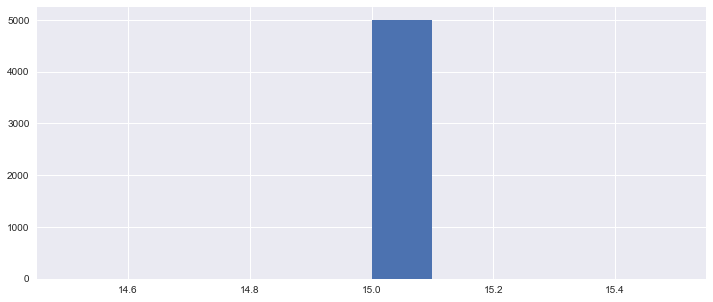

In [9]:
import matplotlib.pyplot as plt

plt.hist(temp);

What about the models trained on the second data set ?

In [10]:
# Loading the datasets. Since the models were trained on the first part of the dataset, we must choose different datasets this
# time, for instance the second subsets
X_train = pd.read_csv('datasets/observations1.csv')
y_train = pd.read_csv('datasets/labels1.csv')
X_train.drop('id',axis=1,inplace=True)
y_train.drop('Unnamed: 0',axis=1,inplace=True);

In [12]:
#Let's import a bunch of the level-0 classifiers
level0_models = []
level0_nn = []

dir_name = 'zero_level_models'
file_list = os.listdir(dir_name)

for f in file_list:        
    if 'model2_' in f:
        with open(dir_name+'/'+f,'rb') as file:
            pickler = pk.Unpickler(file)
            try:
                temp = pickler.load()
                level0_models.append(temp)
            except:
                continue

16


In [13]:
 stackX = stacked_dataset(level0_models, X_train.iloc[:5000,:])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [16]:
temp = np.array(stackX.shape[0]*[0])
for i in range(stackX.shape[0]):
    temp[i] = (stackX[i] == 1).sum()

temp    

array([0, 0, 0, ..., 0, 0, 0])

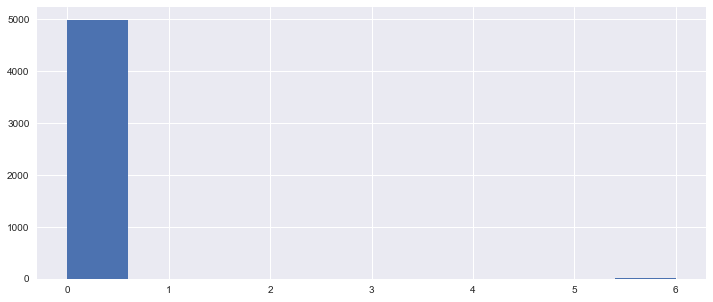

In [17]:
plt.hist(temp);

In [32]:
from sklearn.externals import joblib as jb

model = jb.load('zero_level_models/model1_1.txt')

y = model.predict(X_train_2.iloc[:1000,:])
y

D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
D:\Programmes files (x86)\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,